In [1]:
# Import libraries

from __future__ import print_function   # bring print() function to Python 2
import numpy as np
import matplotlib.pylab as plt
import matplotlib
%matplotlib inline
import tensorflow as tf  
from sklearn import metrics
from numpy import genfromtxt
import random
import pandas as pd

In [2]:
# Model configurations

n_steps = 1000                      # number of time steps
n_hidden = 10                       # number of neurons on each hidden layer
n_classes = 2                       # number of classes
n_features = 4                      # number of features
learning_rate = 0.002                
lambda_loss_amount = 0.001
training_iters = 81000              # Loop 300 times on the dataset
batch_size = 50                     # number of samples feed into the LSTM in each iteration
display_iter = 100                  # To show test set accuracy during training

with open('model_configuration.txt', 'w') as f:
    f.write("n_steps: {}".format(n_steps) + '\n')
    f.write("n_hidden: {}".format(n_hidden) + '\n')
    f.write("n_classes: {}".format(n_classes) + '\n')
    f.write("n_features: {}".format(n_features) + '\n')
    f.write("learning_rate: {}".format(learning_rate) + '\n')
    f.write("lambda_loss_amount: {}".format(lambda_loss_amount) + '\n')
    f.write("training_iters: {}".format(training_iters) + '\n')
    f.write("batch_size: {}".format(batch_size) + '\n')
    f.write("display_iter: {}".format(display_iter) + '\n')

In [3]:
# Load and change data format

# load X data, 4 features

q_df = pd.read_csv("../complete_data_v2/q_5000.csv", delimiter=",", usecols=range(0,n_steps), header=None)
r_df = pd.read_csv("../complete_data_v2/r_5000.csv", delimiter=",", usecols=range(0,n_steps), header=None)
s_df = pd.read_csv("../complete_data_v2/s_5000.csv", delimiter=",", usecols=range(0,n_steps), header=None)
d_df = pd.read_csv("../complete_data_v2/duration_5000.csv", delimiter=",", usecols=range(0,n_steps), header=None)

q = q_df.values
r = r_df.values
s = s_df.values
d = d_df.values

# q = np.loadtxt(open("../complete_data_v2/q_5000.csv", "rb"), delimiter=",", usecols=range(0,n_steps))
# r = np.loadtxt(open("../complete_data_v2/r_5000.csv", "rb"), delimiter=",", usecols=range(0,n_steps))
# s = np.loadtxt(open("../complete_data_v2/s_5000.csv", "rb"), delimiter=",", usecols=range(0,n_steps))
# d = np.loadtxt(open("../complete_data_v2/duration_5000.csv", "rb"), delimiter=",", usecols=range(0,n_steps))

# combine the 2d arrays into a 3d array

multi_3d = np.array([q,r,s,d])

# transpose into the format required by LSTM (samples,time steps,features)

X_data = np.transpose(multi_3d,(1,2,0))

# load Y data

Y_df = pd.read_csv("../complete_data_v2/class_5000_label.csv", delimiter=",", header=None)
Y_data = Y_df[0].values

#Y_data = np.loadtxt(open("../complete_data_v2/class_5000_label.csv", "rb"), delimiter=",")

print('Loading data done')

Loading data done


In [4]:
# split into training and test data (4:1)
# PE: 133:58
# Non PE: 133:34

X_train_p = X_data[:133]
X_train_n = X_data[191:324]
X_train = np.vstack((X_train_p, X_train_n))

X_test_p = X_data[133:191]
X_test_n = X_data[324:]
X_test = np.vstack((X_test_p, X_test_n))

Y_train_p = Y_data[:133]
Y_train_n = Y_data[191:324]
y_train = np.concatenate((Y_train_p, Y_train_n))

Y_test_p = Y_data[133:191]
Y_test_n = Y_data[324:]
y_test = np.concatenate((Y_test_p, Y_test_n))


In [5]:
# shuffle the data to make each batch balanced

np.random.seed(1)

combine_train = list(zip(X_train, y_train))
random.shuffle(combine_train)
X_train_shuffled, y_train_shuffled = zip(*combine_train)
X_train_shuffled = np.asarray(X_train_shuffled)           # change tuple back into array          
y_train_shuffled = np.asarray(y_train_shuffled)

combine_test = list(zip(X_test, y_test))
random.shuffle(combine_test)
X_test_shuffled, y_test_shuffled = zip(*combine_test)
X_test_shuffled = np.asarray(X_test_shuffled)
y_test_shuffled = np.asarray(y_test_shuffled)

print('Transforming data done')

Transforming data done


In [6]:
# The lstm model skeleton function

def LSTM_RNN(_X, _weights, _biases):
    # input shape: (batch_size, n_steps, n_features)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_features]) 
    # new shape: (n_steps*batch_size, n_features)
    
    # Linear activation
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    #lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell] * 3, state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many to one" style classifier, 
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']

In [7]:
# Helper functions

def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s

In [8]:
def one_hot(y_):
    # Function to encode output labels from number indexes 
    
    y_ = y_.reshape(len(y_))
    return np.eye(2)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [9]:
%%time

# Initialize the lstm network with random weights and biases

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_features])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_features, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

print('Initialization done.')


Initialization done.
CPU times: user 4min 37s, sys: 2.98 s, total: 4min 40s
Wall time: 4min 40s


In [10]:
%%time

# Train the model

# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
local = tf.local_variables_initializer()
sess.run(init)
sess.run(local)

with open('train_log.txt', 'w') as f:
    # Perform Training steps with "batch_size" amount of example data at each loop
    step = 1
    while step * batch_size <= training_iters:
        batch_xs =         extract_batch_size(X_train_shuffled, step, batch_size)
        batch_ys = one_hot(extract_batch_size(y_train_shuffled, step, batch_size))

        # Fit training using batch data
        _, loss, acc = sess.run(
            [optimizer, cost, accuracy],
            feed_dict={
                x: batch_xs, 
                y: batch_ys
            }
        )
        train_losses.append(loss)
        train_accuracies.append(acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

            # To not spam console, show training accuracy/loss in this "if"
            f.write("Training iter #" + str(step*batch_size) + \
                  ":   Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc) + '\n')

            # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
            loss, acc = sess.run(
                [cost, accuracy], 
                feed_dict={
                    x: X_test_shuffled,
                    y: one_hot(y_test_shuffled)
                }
            )
            test_losses.append(loss)
            test_accuracies.append(acc)
            f.write("PERFORMANCE ON TEST SET: " + \
                  "Batch Loss = {}".format(loss) + \
                  ", Accuracy = {}".format(acc) + '\n')

        step += 1

    f.write("Optimization Finished!" + '\n')

    # Accuracy for test data

    one_hot_predictions, accuracy, final_loss = sess.run(
        [pred, accuracy, cost],
        feed_dict={
            x: X_test_shuffled,
            y: one_hot(y_test_shuffled)
        }
    )

    test_losses.append(final_loss)
    test_accuracies.append(accuracy)

    f.write("FINAL RESULT: " + \
          "Batch Loss = {}".format(final_loss) + \
          ", Accuracy = {}".format(accuracy) + '\n')
    
print("Training done")


Training done
CPU times: user 48min 40s, sys: 13min 13s, total: 1h 1min 53s
Wall time: 17min 14s


In [11]:
# save the model

saver = tf.train.Saver()
saver.save(sess, 'lstm_1_layer_model')

'lstm_1_layer_model'

In [12]:
# save the losses and accuracies to file

test_result_data = np.column_stack((test_losses, test_accuracies))
train_result_data = np.column_stack((train_losses, train_accuracies))

np.savetxt("test_loss_accuracy.csv", test_result_data, delimiter=",", header="test_loss,test_accuracy")
np.savetxt("train_loss_accuracy.csv", train_result_data, delimiter=",", header="train_loss,train_accuracy")

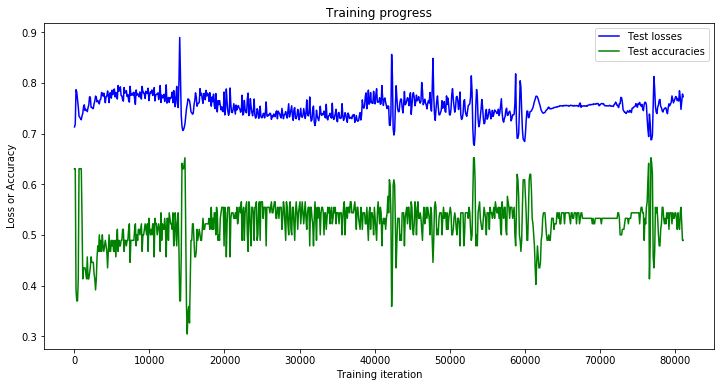

In [13]:
width = 12
height = 6
plt.figure(figsize=(width, height))

# indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
# plt.plot(indep_train_axis, np.array(train_losses),     "c--", label="Train losses")
# plt.plot(indep_train_axis, np.array(train_accuracies), "r--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training progress")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Loss or Accuracy')
plt.xlabel('Training iteration')

plt.savefig('test_results.png')
plt.show()

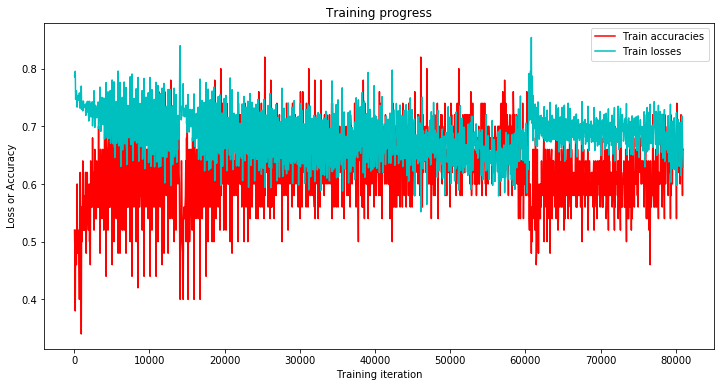

In [14]:
width = 12
height = 6
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_accuracies), "r-", label="Train accuracies")
plt.plot(indep_train_axis, np.array(train_losses),     "c-", label="Train losses")


# indep_test_axis = np.append(
#     np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
#     [training_iters]
# )
# plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
# plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training progress")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Loss or Accuracy')
plt.xlabel('Training iteration')

plt.savefig('train_results.png')
plt.show()

In [15]:
# Classify all data

classification_all = sess.run(
    tf.argmax(pred,1),
    feed_dict={
        x: X_data,
    }
)

np.savetxt("classification_all.csv", classification_all, delimiter=',')

In [16]:
# Get the probability of developing PE

probability_all = sess.run(
    tf.nn.softmax(pred),
    feed_dict={
        x: X_data,
    }
)

np.savetxt('probability_all.csv', probability_all[:,1], delimiter=',')

In [17]:
# results

predictions = one_hot_predictions.argmax(1)

precision = metrics.precision_score(y_test_shuffled, predictions, average="weighted")
recall = metrics.recall_score(y_test_shuffled, predictions, average="weighted")
f1_score = metrics.f1_score(y_test_shuffled, predictions, average="weighted")
auc = metrics.roc_auc_score(y_test_shuffled, predictions, average="weighted")
confusion_matrix = metrics.confusion_matrix(y_test_shuffled, predictions)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

with open('metrics.txt', 'w') as f:
    f.write("Testing Accuracy: {}".format(accuracy) + '\n')
    f.write("Precision: {}".format(precision) + '\n')
    f.write("Recall: {}".format(recall) + '\n')
    f.write("f1_score: {}".format(f1_score) + '\n')
    f.write("AUC: {}".format(auc) + '\n')
    f.write("Confusion Matrix:" + '\n')
    f.write(str(confusion_matrix[0,0]) + ',' + str(confusion_matrix[0,1]) + '\n')
    f.write(str(confusion_matrix[1,0]) + ',' + str(confusion_matrix[1,1]) + '\n')
    f.write("Confusion matrix (normalised to % of total test data):" + '\n')
    f.write(str(normalised_confusion_matrix[0,0]) + ',' + str(normalised_confusion_matrix[0,1]) + '\n')
    f.write(str(normalised_confusion_matrix[1,0]) + ',' + str(normalised_confusion_matrix[1,1]) + '\n')


print("Testing Accuracy: {}%".format(100*accuracy))
print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test_shuffled, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test_shuffled, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test_shuffled, predictions, average="weighted")))
print("AUC: {}%".format(100*metrics.roc_auc_score(y_test_shuffled, predictions, average="weighted")))
print("")
print("Confusion Matrix:")
print(confusion_matrix)
print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)

# # Plot Results: 
# width = 12
# height = 12
# plt.figure(figsize=(width, height))
# plt.imshow(
#     normalised_confusion_matrix, 
#     interpolation='nearest', 
#     cmap=plt.cm.rainbow
# )
# plt.title("Confusion matrix \n(normalised to % of total test data)")
# plt.colorbar()
# tick_marks = np.arange(n_classes)
# plt.xticks(tick_marks, ['PE','Non-PE'], rotation=90)
# plt.yticks(tick_marks, ['PE','Non-PE'])
# plt.tight_layout()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.savefig('confusion_matrix.png')

# # plt.show()

Testing Accuracy: 48.9130437374115%

Precision: 49.811985898942424%
Recall: 48.91304347826087%
f1_score: 49.31419993605341%
AUC: 46.095334685598374%

Confusion Matrix:
[[12 22]
 [25 33]]

Confusion matrix (normalised to % of total test data):
[[ 13.04347801  23.91304398]
 [ 27.17391205  35.86956406]]
